In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [ ]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [ ]:
covid_df  = pd.read_csv('california_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)

train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]
covid_train = covid_train.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_test = covid_test.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Baseline Univariate

In [ ]:
prop_base = Prophet()
prop_base.fit(covid_train)
prop_base_df = prop_base.make_future_dataframe(periods=len(covid_test))
prop_base_pred = prop_base.predict(prop_base_df)
prop_base_train = prop_base.predict(covid_train)
prop_base_test = prop_base.predict(covid_test)

In [ ]:
prophet_df_base = pd.DataFrame(covid_df)
prophet_df_base = prophet_df_base.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_base['ds'] = pd.to_datetime(prophet_df_base['ds'])

prophet_df_base['forecast'] = prop_base_test['yhat']
length1 = len(prophet_df_base) - len(prop_base_test)
forecast1 = pd.concat([pd.Series([np.nan] * length1), prop_base_test['yhat']], ignore_index=True)
prophet_df_base['forecast'] = forecast1

prophet_df_base['preforecast']=prop_base_train['yhat']

prophet_df_base[['y','forecast', 'preforecast']].plot(figsize=(12,8))

In [ ]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_base_test['yhat'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [ ]:
future_baseline = prop_base.make_future_dataframe(periods=len(covid_test))
future_baseline['ds'] = pd.to_datetime(future_baseline['ds'])
forecast_baseline = prop_base.predict(future_baseline)
prop_base.plot_components(forecast_baseline);

In [ ]:
performance_baseline = pd.concat([covid_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(16)], keys=['ds'])

In [ ]:
print('MAE = ', mean_absolute_error(performance_baseline['y'], performance_baseline['yhat']))
print('MASE = ', mase(performance_baseline['y'], performance_baseline['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_baseline['yhat'], performance_baseline['y'])))

## Tuned Univariate

In [ ]:
prop_base.changepoints

In [ ]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window updated to 2021-22 since the 2020 one is out of our window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

In [ ]:
prophet_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative', n_changepoints=25, holidays=events)
prophet_tuned.add_country_holidays(country_name='US')

prophet_tuned.fit(covid_train)
prop_season_train = prophet_tuned.predict(covid_train)
prop_season_test = prophet_tuned.predict(covid_test)

In [ ]:
prophet_df_season = pd.DataFrame(covid_df)
prophet_df_season = prophet_df_season.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_season['ds'] = pd.to_datetime(prophet_df_season['ds'])

prophet_df_season['forecast'] = prop_season_test['yhat']
length2 = len(prophet_df_season) - len(prop_season_test)
forecast2 = pd.concat([pd.Series([np.nan] * length2), prop_season_test['yhat']], ignore_index=True)
prophet_df_season['forecast'] = forecast2

prophet_df_season['preforecast']=prop_season_train['yhat']

prophet_df_season[['y','forecast', 'preforecast']].plot(figsize=(12,8))

In [ ]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_season_test['yhat'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [ ]:
tuned_df = prophet_tuned.make_future_dataframe(periods=len(covid_test))
tuned_df['ds'] = pd.to_datetime(tuned_df['ds'])
forecast_tuned = prop_base.predict(tuned_df)

tunned_performance = pd.concat([covid_test, forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(119)], keys=['ds'])
print('MAE = ', mean_absolute_error(tunned_performance['y'], tunned_performance['yhat']))
print('MASE = ', mase(tunned_performance['y'], tunned_performance['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(tunned_performance['yhat'], tunned_performance['y'])))

## Baseline Multivariate 

In [ ]:
import os
os._exit(00)

In [46]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb

from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [47]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [48]:
covid_df = pd.read_csv('cali_multi_df.csv', parse_dates=['Date'])
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [49]:
covid_train = covid_train[['ds', 'y', 'new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_4_lag', 'new_cases_50_std', 'dew_point', 'new_deaths_100_mean', 'new_deaths_7_lag', 'new_cases_350_lag', 'new_deaths_4_lag', 'new_deaths_50_lag', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'new_cases_150_lag', 'new_cases_50_lag', 'average_temperature_celsius', 'new_deaths_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_10_mean', 'new_cases_10_min', 'new_cases_7_lag', 'new_deaths_2_lag', 'current_intensive_care_patients', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'new_cases_1 lag', 'new_deaths_1_lag']]
covid_test = covid_test[['ds', 'y', 'new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_4_lag', 'new_cases_50_std', 'dew_point', 'new_deaths_100_mean', 'new_deaths_7_lag', 'new_cases_350_lag', 'new_deaths_4_lag', 'new_deaths_50_lag', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'new_cases_150_lag', 'new_cases_50_lag', 'average_temperature_celsius', 'new_deaths_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_10_mean', 'new_cases_10_min', 'new_cases_7_lag', 'new_deaths_2_lag', 'current_intensive_care_patients', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'new_cases_1 lag', 'new_deaths_1_lag']]

In [50]:
multi_prop = Prophet(yearly_seasonality=True, weekly_seasonality=True)

regressors = ['new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_4_lag', 'new_cases_50_std', 'dew_point', 'new_deaths_100_mean', 'new_deaths_7_lag', 'new_cases_350_lag', 'new_deaths_4_lag', 'new_deaths_50_lag', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'new_cases_150_lag', 'new_cases_50_lag', 'average_temperature_celsius', 'new_deaths_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_10_mean', 'new_cases_10_min', 'new_cases_7_lag', 'new_deaths_2_lag', 'current_intensive_care_patients', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'new_cases_1 lag', 'new_deaths_1_lag']
for regressor in regressors:
    multi_prop.add_regressor(regressor, standardize=False)
    
multi_prop.fit(covid_train)

21:16:13 - cmdstanpy - INFO - Chain [1] start processing
21:16:14 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
future_multi = multi_prop.make_future_dataframe(periods=len(covid_test))
future_multi = pd.merge(future_multi, covid_df[['ds', 'vaccination_rate_1dose', 'new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_50_max', 'new_cases_4_lag', 'new_cases_50_min', 'new_deaths_10_min', 'new_deaths_50_max', 'new_cases_50_std', 'Booster_Doses_65Plus', 'maximum_temperature_celsius', 'new_cases_50_mean', 'dew_point', 'new_deaths_100_mean', 'new_deaths_4_lag', 'new_cases_350_lag', 'new_deaths_7_lag', 'new_deaths_50_lag', 'new_deaths_50_min', 'new_deaths_30_lag', 'Administered_Dose1_Recip_5Plus', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'minimum_temperature_celsius', 'new_cases_150_lag', 'new_deaths_50_std', 'new_deaths_10_max', 'new_cases_50_lag', 'new_cases_1 lag', 'Booster_Doses_18Plus', 'average_temperature_celsius', 'Series_Complete_65Plus', 'new_deaths_100_std', 'Completeness_pct', 'new_cases_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_10_std', 'new_deaths_3_lag', 'vaccination_rate_complete', 'Series_Complete_5Plus', 'vaccination_policy', 'new_cases_10_mean', 'new_deaths_100_max', 'new_cases_10_min', 'booster_rate', 'new_cases_7_lag', 'new_deaths_2_lag', 'new_cases_100_min', 'new_deaths_100_min', 'new_cases_100_max', 'rainfall_mm', 'new_cases_100_mean', 'current_intensive_care_patients', 'restrictions_on_gatherings', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'Administered_Dose1_Recip', 'stringency_index', 'facial_coverings', 'new_deaths_1_lag']], on='ds', how='inner')
forecast_multi = multi_prop.predict(future_multi)
forecast_multi['yhat'] = np.clip(forecast_multi['yhat'], 0, None)


In [52]:
covid_test

,ds,y,new_hospitalized_patients,new_cases_2_lag,new_cases_4_lag,new_cases_50_std,dew_point,new_deaths_100_mean,new_deaths_7_lag,new_cases_350_lag,...,new_cases_10_mean,new_cases_10_min,new_cases_7_lag,new_deaths_2_lag,current_intensive_care_patients,new_cases_30_lag,new_deaths_10_mean,relative_humidity,new_cases_1 lag,new_deaths_1_lag
671,2022-01-01,0,1070.0,49354.0,49384.0,12600.508267,2.215278,81.77,2.0,37559.0,...,26440.9,0.0,0.0,96.0,1226.0,9488.0,55.8,84.349997,57646.0,65.0
672,2022-01-02,44710,1157.0,57646.0,30162.0,13501.097496,1.916667,80.02,13.0,31547.0,...,28905.6,0.0,20794.0,65.0,1265.0,7755.0,46.3,81.741111,0.0,0.0
673,2022-01-03,46362,1233.0,0.0,49354.0,14308.401135,2.187500,80.05,36.0,25393.0,...,31508.0,0.0,16668.0,0.0,1282.0,2290.0,42.8,79.667863,44710.0,3.0
674,2022-01-04,141752,1474.0,44710.0,57646.0,23251.014386,4.263889,80.65,85.0,39106.0,...,45683.2,0.0,49384.0,3.0,1398.0,1636.0,50.2,79.885115,46362.0,33.0
675,2022-01-05,59311,1673.0,46362.0,0.0,24043.871442,7.472222,80.50,95.0,19329.0,...,49534.9,0.0,30162.0,33.0,1434.0,17481.0,63.5,86.057175,141752.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,4531,117.0,0.0,2118.0,4052.353343,4.805556,121.57,33.0,2083.0,...,3932.3,0.0,3271.0,0.0,102.0,972.0,37.9,39.134605,0.0,3.0
786,2022-04-26,16180,188.0,0.0,17778.0,4309.562938,5.013889,122.04,92.0,1591.0,...,5550.3,0.0,10275.0,3.0,122.0,0.0,47.7,38.294267,4531.0,30.0
787,2022-04-27,1852,174.0,4531.0,0.0,4319.108918,3.944444,120.95,38.0,1603.0,...,5734.7,0.0,1342.0,30.0,133.0,5431.0,48.5,41.187525,16180.0,98.0
788,2022-04-28,2427,159.0,16180.0,0.0,4322.810224,1.916667,120.53,32.0,1766.0,...,5650.3,0.0,2118.0,98.0,125.0,1288.0,49.2,40.455823,1852.0,16.0


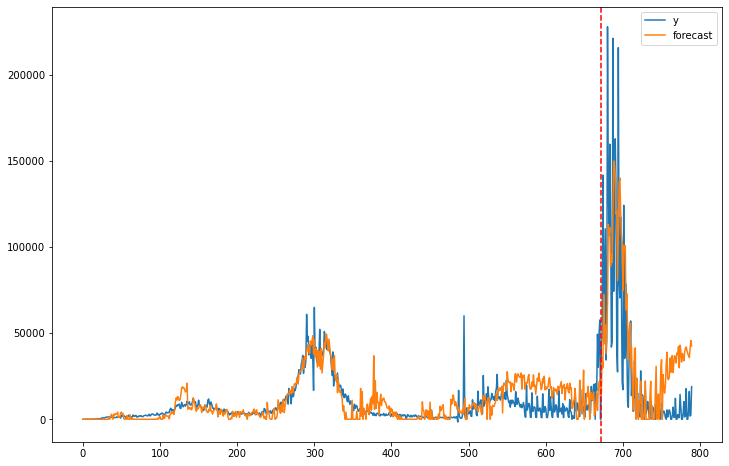

In [53]:
prophet_df_multi = pd.DataFrame(covid_df)
prophet_df_multi = prophet_df_multi.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi['ds'] = pd.to_datetime(prophet_df_multi['ds'])

prophet_df_multi['forecast']=forecast_multi['yhat']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

In [54]:
covid_test

,ds,y,new_hospitalized_patients,new_cases_2_lag,new_cases_4_lag,new_cases_50_std,dew_point,new_deaths_100_mean,new_deaths_7_lag,new_cases_350_lag,...,new_cases_10_mean,new_cases_10_min,new_cases_7_lag,new_deaths_2_lag,current_intensive_care_patients,new_cases_30_lag,new_deaths_10_mean,relative_humidity,new_cases_1 lag,new_deaths_1_lag
671,2022-01-01,0,1070.0,49354.0,49384.0,12600.508267,2.215278,81.77,2.0,37559.0,...,26440.9,0.0,0.0,96.0,1226.0,9488.0,55.8,84.349997,57646.0,65.0
672,2022-01-02,44710,1157.0,57646.0,30162.0,13501.097496,1.916667,80.02,13.0,31547.0,...,28905.6,0.0,20794.0,65.0,1265.0,7755.0,46.3,81.741111,0.0,0.0
673,2022-01-03,46362,1233.0,0.0,49354.0,14308.401135,2.187500,80.05,36.0,25393.0,...,31508.0,0.0,16668.0,0.0,1282.0,2290.0,42.8,79.667863,44710.0,3.0
674,2022-01-04,141752,1474.0,44710.0,57646.0,23251.014386,4.263889,80.65,85.0,39106.0,...,45683.2,0.0,49384.0,3.0,1398.0,1636.0,50.2,79.885115,46362.0,33.0
675,2022-01-05,59311,1673.0,46362.0,0.0,24043.871442,7.472222,80.50,95.0,19329.0,...,49534.9,0.0,30162.0,33.0,1434.0,17481.0,63.5,86.057175,141752.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,4531,117.0,0.0,2118.0,4052.353343,4.805556,121.57,33.0,2083.0,...,3932.3,0.0,3271.0,0.0,102.0,972.0,37.9,39.134605,0.0,3.0
786,2022-04-26,16180,188.0,0.0,17778.0,4309.562938,5.013889,122.04,92.0,1591.0,...,5550.3,0.0,10275.0,3.0,122.0,0.0,47.7,38.294267,4531.0,30.0
787,2022-04-27,1852,174.0,4531.0,0.0,4319.108918,3.944444,120.95,38.0,1603.0,...,5734.7,0.0,1342.0,30.0,133.0,5431.0,48.5,41.187525,16180.0,98.0
788,2022-04-28,2427,159.0,16180.0,0.0,4322.810224,1.916667,120.53,32.0,1766.0,...,5650.3,0.0,2118.0,98.0,125.0,1288.0,49.2,40.455823,1852.0,16.0


In [55]:
graph_df = pd.DataFrame(covid_test['y'])
#graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_hospitalized_patients,new_cases_2_lag,new_cases_4_lag,new_cases_50_std,dew_point,new_deaths_100_mean,new_deaths_7_lag,new_cases_350_lag,...,new_cases_10_mean,new_cases_10_min,new_cases_7_lag,new_deaths_2_lag,current_intensive_care_patients,new_cases_30_lag,new_deaths_10_mean,relative_humidity,new_cases_1 lag,new_deaths_1_lag
671,2022-01-01,0,1070.0,49354.0,49384.0,12600.508267,2.215278,81.77,2.0,37559.0,...,26440.9,0.0,0.0,96.0,1226.0,9488.0,55.8,84.349997,57646.0,65.0
672,2022-01-02,44710,1157.0,57646.0,30162.0,13501.097496,1.916667,80.02,13.0,31547.0,...,28905.6,0.0,20794.0,65.0,1265.0,7755.0,46.3,81.741111,0.0,0.0
673,2022-01-03,46362,1233.0,0.0,49354.0,14308.401135,2.187500,80.05,36.0,25393.0,...,31508.0,0.0,16668.0,0.0,1282.0,2290.0,42.8,79.667863,44710.0,3.0
674,2022-01-04,141752,1474.0,44710.0,57646.0,23251.014386,4.263889,80.65,85.0,39106.0,...,45683.2,0.0,49384.0,3.0,1398.0,1636.0,50.2,79.885115,46362.0,33.0
675,2022-01-05,59311,1673.0,46362.0,0.0,24043.871442,7.472222,80.50,95.0,19329.0,...,49534.9,0.0,30162.0,33.0,1434.0,17481.0,63.5,86.057175,141752.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,4531,117.0,0.0,2118.0,4052.353343,4.805556,121.57,33.0,2083.0,...,3932.3,0.0,3271.0,0.0,102.0,972.0,37.9,39.134605,0.0,3.0
786,2022-04-26,16180,188.0,0.0,17778.0,4309.562938,5.013889,122.04,92.0,1591.0,...,5550.3,0.0,10275.0,3.0,122.0,0.0,47.7,38.294267,4531.0,30.0
787,2022-04-27,1852,174.0,4531.0,0.0,4319.108918,3.944444,120.95,38.0,1603.0,...,5734.7,0.0,1342.0,30.0,133.0,5431.0,48.5,41.187525,16180.0,98.0
788,2022-04-28,2427,159.0,16180.0,0.0,4322.810224,1.916667,120.53,32.0,1766.0,...,5650.3,0.0,2118.0,98.0,125.0,1288.0,49.2,40.455823,1852.0,16.0


In [56]:
graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_hospitalized_patients,new_cases_2_lag,new_cases_4_lag,new_cases_50_std,dew_point,new_deaths_100_mean,new_deaths_7_lag,new_cases_350_lag,...,new_cases_10_mean,new_cases_10_min,new_cases_7_lag,new_deaths_2_lag,current_intensive_care_patients,new_cases_30_lag,new_deaths_10_mean,relative_humidity,new_cases_1 lag,new_deaths_1_lag
671,2022-01-01,0,1070.0,49354.0,49384.0,12600.508267,2.215278,81.77,2.0,37559.0,...,26440.9,0.0,0.0,96.0,1226.0,9488.0,55.8,84.349997,57646.0,65.0
672,2022-01-02,44710,1157.0,57646.0,30162.0,13501.097496,1.916667,80.02,13.0,31547.0,...,28905.6,0.0,20794.0,65.0,1265.0,7755.0,46.3,81.741111,0.0,0.0
673,2022-01-03,46362,1233.0,0.0,49354.0,14308.401135,2.187500,80.05,36.0,25393.0,...,31508.0,0.0,16668.0,0.0,1282.0,2290.0,42.8,79.667863,44710.0,3.0
674,2022-01-04,141752,1474.0,44710.0,57646.0,23251.014386,4.263889,80.65,85.0,39106.0,...,45683.2,0.0,49384.0,3.0,1398.0,1636.0,50.2,79.885115,46362.0,33.0
675,2022-01-05,59311,1673.0,46362.0,0.0,24043.871442,7.472222,80.50,95.0,19329.0,...,49534.9,0.0,30162.0,33.0,1434.0,17481.0,63.5,86.057175,141752.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,4531,117.0,0.0,2118.0,4052.353343,4.805556,121.57,33.0,2083.0,...,3932.3,0.0,3271.0,0.0,102.0,972.0,37.9,39.134605,0.0,3.0
786,2022-04-26,16180,188.0,0.0,17778.0,4309.562938,5.013889,122.04,92.0,1591.0,...,5550.3,0.0,10275.0,3.0,122.0,0.0,47.7,38.294267,4531.0,30.0
787,2022-04-27,1852,174.0,4531.0,0.0,4319.108918,3.944444,120.95,38.0,1603.0,...,5734.7,0.0,1342.0,30.0,133.0,5431.0,48.5,41.187525,16180.0,98.0
788,2022-04-28,2427,159.0,16180.0,0.0,4322.810224,1.916667,120.53,32.0,1766.0,...,5650.3,0.0,2118.0,98.0,125.0,1288.0,49.2,40.455823,1852.0,16.0


,ds,y,new_hospitalized_patients,new_cases_2_lag,new_cases_4_lag,new_cases_50_std,dew_point,new_deaths_100_mean,new_deaths_7_lag,new_cases_350_lag,...,new_cases_10_mean,new_cases_10_min,new_cases_7_lag,new_deaths_2_lag,current_intensive_care_patients,new_cases_30_lag,new_deaths_10_mean,relative_humidity,new_cases_1 lag,new_deaths_1_lag
671,2022-01-01,0,1070.0,49354.0,49384.0,12600.508267,2.215278,81.77,2.0,37559.0,...,26440.9,0.0,0.0,96.0,1226.0,9488.0,55.8,84.349997,57646.0,65.0
672,2022-01-02,44710,1157.0,57646.0,30162.0,13501.097496,1.916667,80.02,13.0,31547.0,...,28905.6,0.0,20794.0,65.0,1265.0,7755.0,46.3,81.741111,0.0,0.0
673,2022-01-03,46362,1233.0,0.0,49354.0,14308.401135,2.187500,80.05,36.0,25393.0,...,31508.0,0.0,16668.0,0.0,1282.0,2290.0,42.8,79.667863,44710.0,3.0
674,2022-01-04,141752,1474.0,44710.0,57646.0,23251.014386,4.263889,80.65,85.0,39106.0,...,45683.2,0.0,49384.0,3.0,1398.0,1636.0,50.2,79.885115,46362.0,33.0
675,2022-01-05,59311,1673.0,46362.0,0.0,24043.871442,7.472222,80.50,95.0,19329.0,...,49534.9,0.0,30162.0,33.0,1434.0,17481.0,63.5,86.057175,141752.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,4531,117.0,0.0,2118.0,4052.353343,4.805556,121.57,33.0,2083.0,...,3932.3,0.0,3271.0,0.0,102.0,972.0,37.9,39.134605,0.0,3.0
786,2022-04-26,16180,188.0,0.0,17778.0,4309.562938,5.013889,122.04,92.0,1591.0,...,5550.3,0.0,10275.0,3.0,122.0,0.0,47.7,38.294267,4531.0,30.0
787,2022-04-27,1852,174.0,4531.0,0.0,4319.108918,3.944444,120.95,38.0,1603.0,...,5734.7,0.0,1342.0,30.0,133.0,5431.0,48.5,41.187525,16180.0,98.0
788,2022-04-28,2427,159.0,16180.0,0.0,4322.810224,1.916667,120.53,32.0,1766.0,...,5650.3,0.0,2118.0,98.0,125.0,1288.0,49.2,40.455823,1852.0,16.0


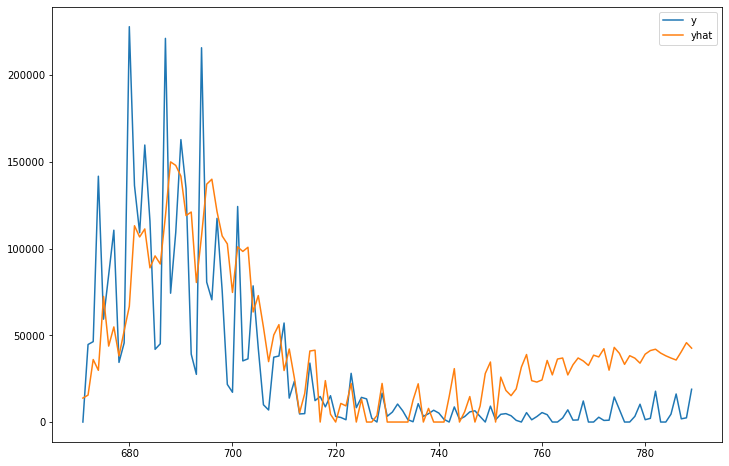

In [57]:
graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

In [58]:
covid_test

,ds,y,new_hospitalized_patients,new_cases_2_lag,new_cases_4_lag,new_cases_50_std,dew_point,new_deaths_100_mean,new_deaths_7_lag,new_cases_350_lag,...,new_cases_10_mean,new_cases_10_min,new_cases_7_lag,new_deaths_2_lag,current_intensive_care_patients,new_cases_30_lag,new_deaths_10_mean,relative_humidity,new_cases_1 lag,new_deaths_1_lag
671,2022-01-01,0,1070.0,49354.0,49384.0,12600.508267,2.215278,81.77,2.0,37559.0,...,26440.9,0.0,0.0,96.0,1226.0,9488.0,55.8,84.349997,57646.0,65.0
672,2022-01-02,44710,1157.0,57646.0,30162.0,13501.097496,1.916667,80.02,13.0,31547.0,...,28905.6,0.0,20794.0,65.0,1265.0,7755.0,46.3,81.741111,0.0,0.0
673,2022-01-03,46362,1233.0,0.0,49354.0,14308.401135,2.187500,80.05,36.0,25393.0,...,31508.0,0.0,16668.0,0.0,1282.0,2290.0,42.8,79.667863,44710.0,3.0
674,2022-01-04,141752,1474.0,44710.0,57646.0,23251.014386,4.263889,80.65,85.0,39106.0,...,45683.2,0.0,49384.0,3.0,1398.0,1636.0,50.2,79.885115,46362.0,33.0
675,2022-01-05,59311,1673.0,46362.0,0.0,24043.871442,7.472222,80.50,95.0,19329.0,...,49534.9,0.0,30162.0,33.0,1434.0,17481.0,63.5,86.057175,141752.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,4531,117.0,0.0,2118.0,4052.353343,4.805556,121.57,33.0,2083.0,...,3932.3,0.0,3271.0,0.0,102.0,972.0,37.9,39.134605,0.0,3.0
786,2022-04-26,16180,188.0,0.0,17778.0,4309.562938,5.013889,122.04,92.0,1591.0,...,5550.3,0.0,10275.0,3.0,122.0,0.0,47.7,38.294267,4531.0,30.0
787,2022-04-27,1852,174.0,4531.0,0.0,4319.108918,3.944444,120.95,38.0,1603.0,...,5734.7,0.0,1342.0,30.0,133.0,5431.0,48.5,41.187525,16180.0,98.0
788,2022-04-28,2427,159.0,16180.0,0.0,4322.810224,1.916667,120.53,32.0,1766.0,...,5650.3,0.0,2118.0,98.0,125.0,1288.0,49.2,40.455823,1852.0,16.0


In [59]:
performance_multi = pd.merge(covid_test, forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE = ', mean_absolute_error(performance_multi['y'], performance_multi['yhat']))
print('MASE = ', mase(performance_multi['y'], performance_multi['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE =  27499.703204932117
MASE =  1.1757187643776161
RMSE =  37563.46453266364


## Tuned Multivariate

In [39]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(covid_train)  # Fit model with given params
    df_cv = cross_validation(m, initial='200 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

20:56:39 - cmdstanpy - INFO - Chain [1] start processing
20:56:39 - cmdstanpy - INFO - Chain [1] done processing
20:56:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:56:39 - cmdstanpy - INFO - Chain [1] start processing
20:56:40 - cmdstanpy - INFO - Chain [1] done processing
20:56:48 - cmdstanpy - INFO - Chain [1] start processing
20:56:48 - cmdstanpy - INFO - Chain [1] done processing
20:56:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:56:48 - cmdstanpy - INFO - Chain [1] start processing
20:56:49 - cmdstanpy - INFO - Chain [1] done processing
20:56:56 - cmdstanpy - INFO - Chain [1] start processing
20:56:56 - cmdstanpy - INFO - Chain [1] done processing
20:56:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Optimization terminated abnormally. Falling back to Newton.
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
21:00:29 - cmdstanpy - INFO - Chain [1] done processing
21:00:39 - cmdstanpy - INFO - Chain [1] start processing
21:00:39 - cmdstanpy - INFO - Chain [1] done processing
21:00:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:39 - cmdstanpy - INFO - Chain [1] start processing
21:00:40 - cmdstanpy - INFO - Chain [1] done processing
21:00:51 - cmdstanpy - INFO - Chain [1] start processing
21:00:51 - cmdstanpy - INFO - Chain [1] done processing
21:00:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:51 - cmdstanpy - INFO - Chain [1] start processing
21:00:52 - cmdstanpy - INFO - Chain [1] done processing
21:01:01 - cmdstanpy - INFO - Chain [1] start processing
21:01:

21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:55 - cmdstanpy - INFO - Chain [1] start processing
21:07:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:14 - cmdstanpy - INFO - Chain [1] start processing
21:08:14 - cmdstanpy - INFO - Chain [1] done processing
21:08:23 - cmdstanpy - INFO - Chain [1] start processing
21:08:23 - cmdstanpy - INFO - Chain [1] done processing
21:08:31 - cmdstanpy - INFO - Chain [1] start processing
21:08:31 - cmdstanpy - INFO - Chain [1] done processing
21:08:38 - cmdstanpy - INFO - Chain [1] start processing
21:08:39 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] 

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode          rmse  
0           ad

In [40]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [60]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window updated to 2021-22 since the 2020 one is out of our window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [61]:
model_holiday_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=True, n_changepoints=4, seasonality_prior_scale=10.0)
model_holiday_tuned.add_country_holidays(country_name='US')

regressors = ['new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_4_lag', 'new_cases_50_std', 'dew_point', 'new_deaths_100_mean', 'new_deaths_7_lag', 'new_cases_350_lag', 'new_deaths_4_lag', 'new_deaths_50_lag', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'new_cases_150_lag', 'new_cases_50_lag', 'average_temperature_celsius', 'new_deaths_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_10_mean', 'new_cases_10_min', 'new_cases_7_lag', 'new_deaths_2_lag', 'current_intensive_care_patients', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'new_cases_1 lag', 'new_deaths_1_lag']
for regressor in regressors:
    model_holiday_tuned.add_regressor(regressor, standardize=False)

model_holiday_tuned.fit(covid_train)

21:16:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:33 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
future_holiday_tuned = model_holiday_tuned.make_future_dataframe(periods=len(covid_test))

future_holiday_tuned = pd.merge(future_holiday_tuned, covid_df[['ds', 'vaccination_rate_1dose', 'new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_50_max', 'new_cases_4_lag', 'new_cases_50_min', 'new_deaths_10_min', 'new_deaths_50_max', 'new_cases_50_std', 'Booster_Doses_65Plus', 'maximum_temperature_celsius', 'new_cases_50_mean', 'dew_point', 'new_deaths_100_mean', 'new_deaths_4_lag', 'new_cases_350_lag', 'new_deaths_7_lag', 'new_deaths_50_lag', 'new_deaths_50_min', 'new_deaths_30_lag', 'Administered_Dose1_Recip_5Plus', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'minimum_temperature_celsius', 'new_cases_150_lag', 'new_deaths_50_std', 'new_deaths_10_max', 'new_cases_50_lag', 'new_cases_1 lag', 'Booster_Doses_18Plus', 'average_temperature_celsius', 'Series_Complete_65Plus', 'new_deaths_100_std', 'Completeness_pct', 'new_cases_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_10_std', 'new_deaths_3_lag', 'vaccination_rate_complete', 'Series_Complete_5Plus', 'vaccination_policy', 'new_cases_10_mean', 'new_deaths_100_max', 'new_cases_10_min', 'booster_rate', 'new_cases_7_lag', 'new_deaths_2_lag', 'new_cases_100_min', 'new_deaths_100_min', 'new_cases_100_max', 'rainfall_mm', 'new_cases_100_mean', 'current_intensive_care_patients', 'restrictions_on_gatherings', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'Administered_Dose1_Recip', 'stringency_index', 'facial_coverings', 'new_deaths_1_lag']], on='ds', how='inner')
future_holiday_tuned = future_holiday_tuned.fillna(method='ffill')

forecast_holiday_tuned = model_holiday_tuned.predict(future_holiday_tuned)
forecast_holiday_tuned['yhat'] = np.clip(forecast_holiday_tuned['yhat'], 0, None)

forecast_holiday_tuned

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,-12.811210,-81664.789533,62027.089049,-12.811210,-12.811210,0.0,0.0,0.0,0.0,...,-117.751297,-117.751297,-117.751297,214.046972,214.046972,214.046972,0.0,0.0,0.0,0.000000
1,2020-03-02,72.896303,-77117.341224,60884.892867,72.896303,72.896303,0.0,0.0,0.0,0.0,...,41.629479,41.629479,41.629479,192.974811,192.974811,192.974811,0.0,0.0,0.0,0.000000
2,2020-03-03,158.603817,-77466.543712,53564.581412,158.603817,158.603817,0.0,0.0,0.0,0.0,...,-55.967593,-55.967593,-55.967593,176.628805,176.628805,176.628805,0.0,0.0,0.0,0.000000
3,2020-03-04,244.311331,-81662.249204,61443.974165,244.311331,244.311331,0.0,0.0,0.0,0.0,...,-42.956605,-42.956605,-42.956605,164.916275,164.916275,164.916275,0.0,0.0,0.0,0.000000
4,2020-03-05,330.018844,-86702.408923,58361.693753,330.018844,330.018844,0.0,0.0,0.0,0.0,...,85.933782,85.933782,85.933782,157.603784,157.603784,157.603784,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,67250.063259,-39110.243262,105705.636508,67249.359711,67250.665141,0.0,0.0,0.0,0.0,...,41.629479,41.629479,41.629479,652.407638,652.407638,652.407638,0.0,0.0,0.0,35574.595089
786,2022-04-26,67335.748710,-29699.194528,109913.316255,67335.032873,67336.368244,0.0,0.0,0.0,0.0,...,-55.967593,-55.967593,-55.967593,671.042467,671.042467,671.042467,0.0,0.0,0.0,39636.314647
787,2022-04-27,67421.434162,-26641.670828,112198.268180,67420.703904,67422.080208,0.0,0.0,0.0,0.0,...,-42.956605,-42.956605,-42.956605,683.022682,683.022682,683.022682,0.0,0.0,0.0,41781.121705
788,2022-04-28,67507.119613,-18540.153687,115606.907856,67506.392635,67507.786006,0.0,0.0,0.0,0.0,...,85.933782,85.933782,85.933782,688.314171,688.314171,688.314171,0.0,0.0,0.0,46944.896389


In [63]:
performance_holiday_tuned = pd.merge(covid_test, forecast_holiday_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE =', mean_absolute_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('MASE = ', mase(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE = 29198.327514427056
MASE =  1.2483415290459627
RMSE =  37563.46453266364


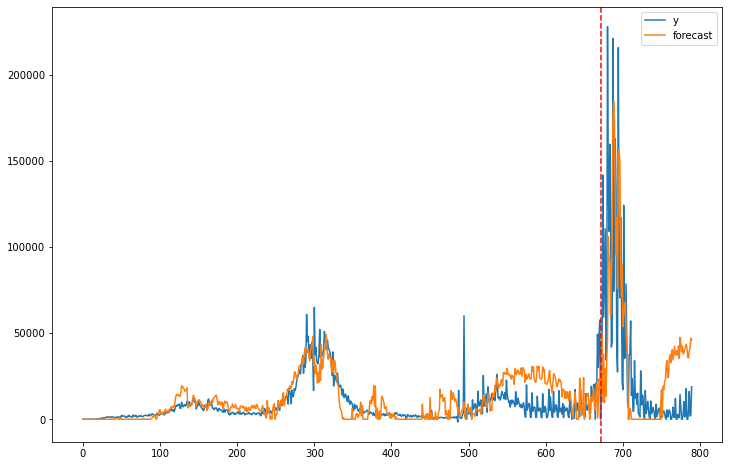

In [64]:
prophet_df_multi_tuned = pd.DataFrame(covid_df)
prophet_df_multi_tuned = prophet_df_multi_tuned.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi_tuned['ds'] = pd.to_datetime(prophet_df_multi_tuned['ds'])

prophet_df_multi_tuned['forecast']=forecast_holiday_tuned['yhat']

prophet_df_multi_tuned[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

<AxesSubplot:>

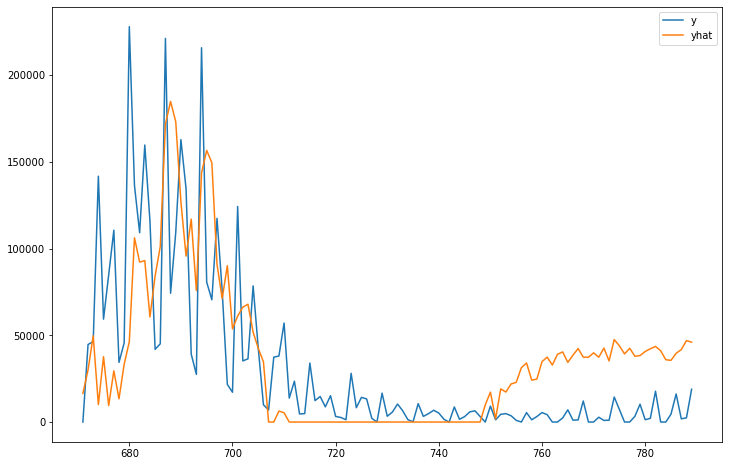

In [65]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prophet_df_multi_tuned['forecast'].tail(119).values
graph_df[['y','yhat']].plot(figsize=(12,8))